<a href="https://colab.research.google.com/github/ikbenali/ReproducibilityProject_DL/blob/main/Reproducibility_project_PINN's_NTK_perspective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CS4240: Reproducibility project

**Paper**: PINNs through a NTK perspective

Setup

In [165]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

1D Poisson PDE functions

In [166]:
# Forcing function
def f(x):
    return -16 * np.pi ** 2 * torch.sin(4 * np.pi * x)

# Boundary condition
def g(x):
    return torch.zeros_like(x)

PINN Class

In [167]:
class PINN(nn.Module):

      def __init__(self, input_size, neurons, output_size):
        super(PINN, self).__init__()
        
        # Define layers
        self.layer1 = nn.Linear(input_size, neurons)
        self.sigmoid = nn.Sigmoid()
        self.layer2 = nn.Linear(neurons, output_size)


      def forward(self, x):
        
        # Calculate output of each layer for input x
        x.requires_grad_(True)
        u1 = self.layer1(x)
        a = self.sigmoid(u1)
        uhat = self.layer2(a)
        
        # Calculate second derivative of uhat: 'uhat_xx'
        uhat_x = torch.autograd.grad(uhat, x, grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
        uhat_xx = torch.autograd.grad(uhat_x, x, grad_outputs=torch.ones_like(uhat_x), create_graph=True)[0]

        return uhat, uhat_xx


Model

In [168]:
# Initialize model
model = PINN(input_size=1, neurons=500, output_size=1)

Loss function

In [169]:
def loss_fn(uhat, uhat_xx, x):
    
    # Calculate residual loss term
    f_x = f(x)
    residual_loss = torch.mean((uhat_xx - f_x)**2)

    # Calculate residual boundary loss term
    g_0 = g(x[0])
    g_1 = g(x[-1])
    boundary_loss = torch.mean((uhat[0] - g_0)**2) + torch.mean((uhat[-1] - g_1)**2)

    # Calculate total loss
    loss = residual_loss + boundary_loss

    return loss

Optimization

In [170]:
# Stochastic gradient descent
SGD = torch.optim.SGD(model.parameters(), lr=1e-3)

# Adam
Adam = torch.optim.Adam(model.parameters(), lr=1e-3)

Training loop

Epoch [1000/10000], Loss: 10799.2891


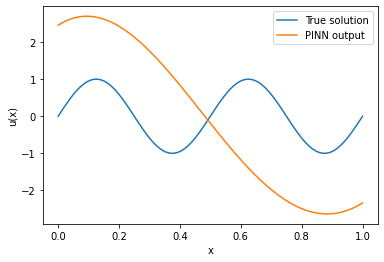

Epoch [2000/10000], Loss: 11056.7793


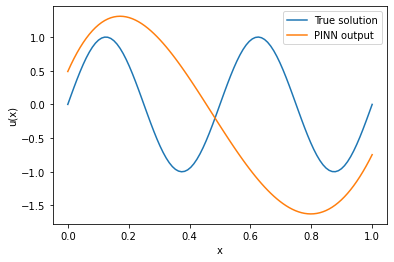

Epoch [3000/10000], Loss: 10339.2529


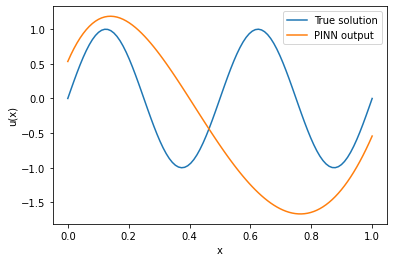

Epoch [4000/10000], Loss: 9582.8086


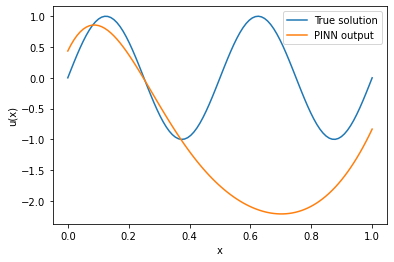

Epoch [5000/10000], Loss: 5861.9048


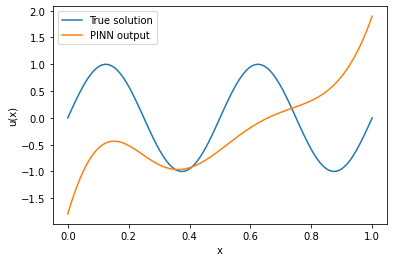

Epoch [6000/10000], Loss: 2353.6382


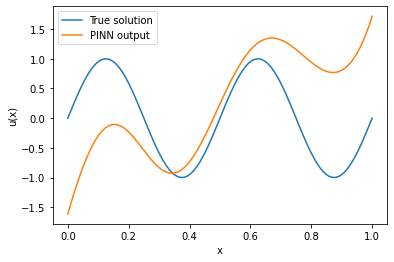

Epoch [7000/10000], Loss: 869.6722


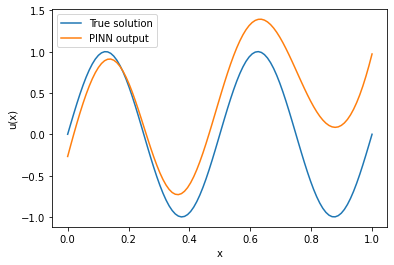

Epoch [8000/10000], Loss: 343.9109


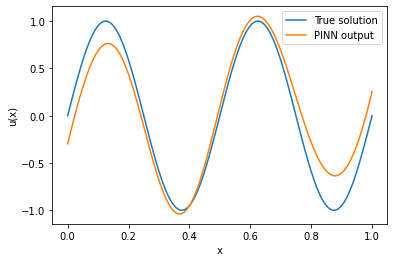

Epoch [9000/10000], Loss: 116.6041


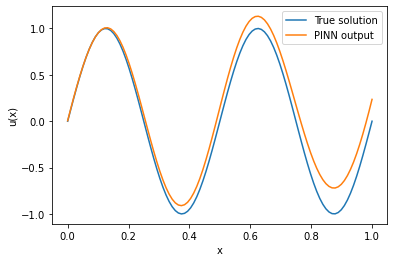

Epoch [10000/10000], Loss: 38.2936


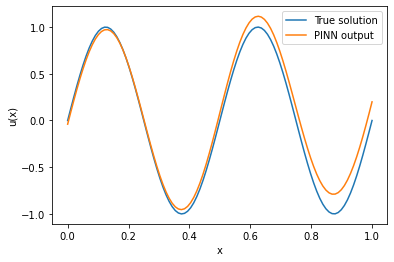

In [171]:
num_epochs = 10000
for epoch in range(num_epochs):
    
    # Generate N random samples within interval [0 1], including '0' and '1'
    N = 500
    x = torch.cat((torch.zeros(1, 1), torch.rand(N-2, 1), torch.ones(1, 1)), dim=0)

    # Predict u(x) using PINN
    uhat, uhat_xx = model(x)

    # Calculate loss 
    loss = loss_fn(uhat, uhat_xx, x)

    # Optimization
    Adam.zero_grad()
    loss.backward()
    Adam.step()

    # Show loss after every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

        # Plot true solution vs PINN output
        x_test = torch.linspace(0, 1, 100).reshape(-1, 1)
        u_true = torch.sin(4 * np.pi * x_test).detach().numpy()
        uhat = model(x_test)[0].detach().numpy()

        plt.plot(x_test.detach().numpy(), u_true, label='True solution')
        plt.plot(x_test.detach().numpy(), uhat, label='PINN output')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.legend()
        plt.show()
